In [281]:
import numpy as np
from scipy.stats import t, gamma, invgamma
import matplotlib.pyplot as plt

# Markov Chain Monte Carlo

In this notebook we will walk through the Markov Chain Monte Carlo method to estimate the mean and variance of the posterior distribution without having to solve for the analytical solution.

## Monte Carlo Sampling

## Markov Chain

### Markov Assumption

### Example: Discrete Markov Chain

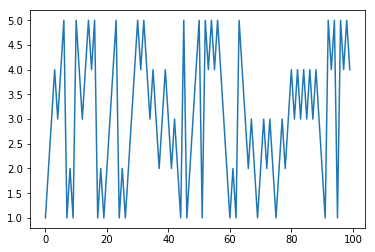

In [49]:
n = 100
num = np.zeros(n)

# take the first number randomly
num[0] = np.random.randint(1, 6)

for ind in range(1, n):
    coin = np.random.randint(0, 2)
    num[ind] = num[ind-1] + 1 if coin else num[ind-1] - 1
    
    if num[ind] == 0:
        num[ind] = 5
    elif num[ind] == 6:
        num[ind] = 1
    
plt.plot(num);

Does this qualify as a Markov Chain? yes it does! because the probability of the next value only depends on the current number and not the history of the numbers.

### Example: Continuous Markov Chain (Random Walk)

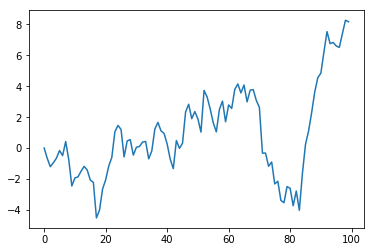

In [46]:
n = 100
states = np.zeros(n)

for ind in range(1, n):
    states[ind] = np.random.normal(loc=states[ind-1], scale=1.0)
    
plt.plot(states);

### Transition matrix (and probability of the nth state)

In [67]:
transition_mat = np.array([[0., .5, 0., 0., .5],
                           [.5, 0., .5, 0., 0.],
                           [0., .5, 0., .5, 0.],
                           [0., 0., .5, 0., .5],
                           [.5, 0., 0., .5, 0.]])

# probability of state transition 2 states from now
transition_mat2 = np.dot(transition_mat, transition_mat)

# probability of ending up in state 3, given we are in state 1 now
transition_mat2[0, 2]

0.25

### Stationary distribution

Suppose we want to know the probability distribution of our number (from 1 to 5) in a distant future. That is $P(X_{t+h}|X_{t})$ where h is a large number.

In [69]:
h = 5
transition_mat5 = transition_mat
for i in range(1, h):
    transition_mat5 = np.dot(transition_mat5, transition_mat5)

transition_mat5

array([[ 0.21347046,  0.18910217,  0.2041626 ,  0.2041626 ,  0.18910217],
       [ 0.18910217,  0.21347046,  0.18910217,  0.2041626 ,  0.2041626 ],
       [ 0.2041626 ,  0.18910217,  0.21347046,  0.18910217,  0.2041626 ],
       [ 0.2041626 ,  0.2041626 ,  0.18910217,  0.21347046,  0.18910217],
       [ 0.18910217,  0.2041626 ,  0.2041626 ,  0.18910217,  0.21347046]])

In [70]:
h = 10
transition_mat10 = transition_mat
for i in range(1, h):
    transition_mat10 = np.dot(transition_mat10, transition_mat10)

transition_mat10

array([[ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2]])

In [96]:
n = 10000
num = np.zeros(n)

# take the first number randomly
num[0] = np.random.randint(1, 6)

for ind in range(1, n):
    coin = np.random.randint(0, 2)
    num[ind] = num[ind-1] + 1 if coin else num[ind-1] - 1
    
    if num[ind] == 0:
        num[ind] = 5
    elif num[ind] == 6:
        num[ind] = 1

In [111]:
counts, edges = np.histogram(num, bins=5)

In [116]:
counts / n

array([ 0.1956,  0.2028,  0.2086,  0.2001,  0.1929])

**Note** that is is approaching the stationary distribution

The random walk example does not have a stationary distribution, but we can modify it so that it does have one.

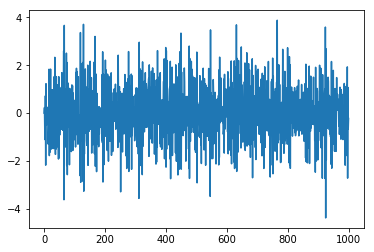

In [134]:
n = 1000
states = np.zeros(n)
phi = -.6  # np.random.random() * 2 - 1 # phi between -1 and 1

for ind in range(1, n):
    states[ind] = np.random.normal(loc= phi * states[ind-1], scale=1.0)
    
plt.plot(states);

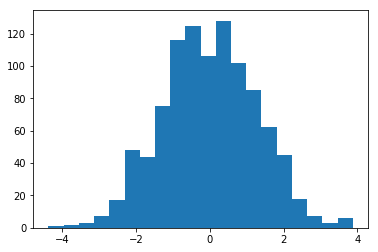

In [137]:
plt.hist(states, bins=20);

## Metropolis Hasting MCMC

Metropolis hasting is an algorithm that allows us to sample from a geenric probability distribution, the *target distribution*, even if we do not know the normalizing constant (remember the Bayes Theorem). To do this we constract and sample from a Markov Chain, whose stationary distribution is the target distribution.


Let;s assume the paramter of interest is $\theta$ (we are interested in the probability distribution of $\theta$)
Here is the algorithm:
- Select an initial value $\theta_{o}$
- Draw a candidate (possible next state) $\theta^{*}$ from the proposal distribution $q(\theta^{*}|\theta_{i-1})$
- Compute the accpetance probability $\alpha$ (whether or not to accept the proposed next state) as follow: <br>
$$\frac{g(\theta^{*})}{g(\theta_{i-1})} \times \frac{q(\theta^{*}|\theta_{i-1})}{q(\theta_{i-1}|\theta^{*})}$$
    - if $\alpha \geq 1$, accept $\theta^{*}$ and $\theta_{i} = \theta^{*}$
    - if $\alpha < 1$, accept $\theta^{*}$ with probability $\alpha$.$^{1}$



$^{1}$How to accept something with probability?

### Exmaple: is this the fair coin (p=.5) or the loaded coin (p=.7)?

In [140]:
from math import factorial

In [150]:
fair_prior = .4
loaded_prior = .6

fact = factorial(5)/(factorial(2) * factorial(3))
fair_likelihood = fact * .5**2 * .5**3
loaded_likelihood = fact * .7**2 * .3**3

In [149]:
print(fact, fair_likelihood, loaded_likelihood)

10.0 0.3125 0.13229999999999997


In [152]:
fair_g = fair_likelihood * fair_prior
loaded_g = loaded_likelihood * loaded_prior

In [153]:
print(fair_g, loaded_g)

0.125 0.07937999999999998


Now we are ready to do the Metropolis Hasting algorithm to compute the posteriors:
- we have our $g(\theta) = \{fair, loaded\}$. Hence our states are "fair" and "loaded"
- we need a proposal distribution. We chooe is to result in the following: we always make a transition to the other state, that is if we are in the "loaded" state we go to "fair" and vice versa. this makes the $q(\theta_{i-1}|\theta^{*})$ and $q(\theta^{*}|\theta_{i-1})$ equal to $1$, because we have a deterministic proposal - we are always proposing to move to the other state.

So for many iterations: <br>
- we pick a random state to start
- compute the acceptance/transition probability, and decide whether to make a transition to the newly proposed state or not.

However, with the given scenraio we dont necessarily need to run a simulation. becuase we are gonna be faced with only two possible situations:
- if proposed state $\theta^{*}$ is **loaded**, then $\alpha = \frac{loaded_g}{fair_g} = \frac{.0794}{.125} = .635$
- if proposed state $\theta^{*}$ is **fair**, then $\alpha = \frac{fair_g}{loaded_g} = \frac{.125}{.0794} = 1.574$

What does this mean?

This means: 
- if the current state is loaded, and the propsoed next state is fair, then we should move from loaded to fair state with a probability of 1.
- if the current state is fair, and the proposed next state is loaded, then we should move form fair state to the loaded state with probability of .635 (and stay in the fair state with probability of 1 - .635 = .365)

In [154]:
from random import sample

In [ ]:
def new_state(states, current_state):
    proposed_state = 

In [270]:
states = ["fair", "loaded"]
current_state = sample(states, 1)[0]

n = 100
proposed_state = current_state
alpha = 0

states_arr = np.zeros(n)

for ind in range(n):
    # propose a new state
    proposed_state = states[1-states.index(current_state)]
    
    # compute the acceptance probabbility
    alpha = fair_g/loaded_g if proposed_state == 'fair' else loaded_g/fair_g
    if alpha >= np.random.uniform():
        states_arr[ind] = 1-states.index(current_state)
    else:
        states_arr[ind] = states.index(current_state)

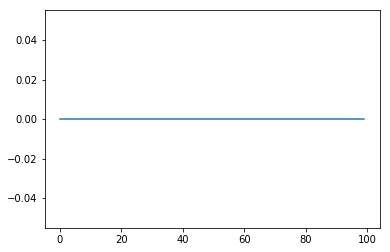

In [271]:
plt.plot(states_arr)

### Example 2: Percentage change in the number of personnel from last year to this year

In [2]:
def lg(mu, n, ybar):
    mu2 = np.square(mu)
    return n * (ybar * mu - mu2 / 2) - np.log(1 + mu2)

In [99]:
def mh(n, ybar, n_iter, mu_init, cand_std):
    mu_out = np.zeros(n_iter)
    accept = 0
    mu_trace = np.zeros(n_iter)
    mu_trace[0] = mu_init
    
    for ind in range(1, n_iter):       
        # draw a candidate state from the proposal distribution (normal distribution)
        mu_proposed = np.random.normal(loc=mu_trace[ind-1], scale=cand_std)
        
        # compute the acceptance ratio (since this is a normal dsitribution, it is symmetric and we dont need the q ratios)
        log_alpha = lg(mu_proposed, n, ybar) - lg(mu_trace[ind-1], n, ybar)  # division at log scale -> subtraction
        alpha = np.exp(log_alpha)
        
        # accept or reject
        check = np.random.uniform()
        if alpha > check:
            mu_trace[ind] = mu_proposed
            accept += 1
        else: 
            mu_trace[ind] = mu_trace[ind-1]
    
    return mu_trace, accept / n_iter

In [108]:
# generate some data
y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, .99, 0.1, 1.3, 1.9])

ybar = np.mean(y)
n = y.shape[0]

# the prior
t_range = np.arange(-1, 3, .01)
t_vals = t.pdf(t_range, df=1, loc=0, scale=1)

# Let's sample from our posterior
np.random.seed(27)
trace, accept = mh(n=n, ybar=ybar, n_iter=1000, mu_init=.0, cand_std=.9)

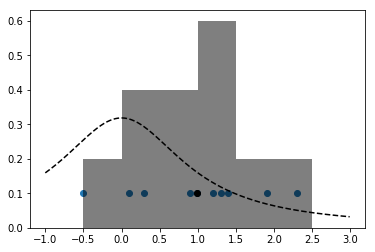

In [109]:
plt.hist(y, bins=np.arange(-.5, 3, .5), histtype='bar', alpha=.5, density=True, color='k');
plt.scatter(y, np.ones(y.shape) * .1, marker='o')
plt.scatter(ybar, .1, c='k')
plt.plot(t_range, t_vals, 'k--')

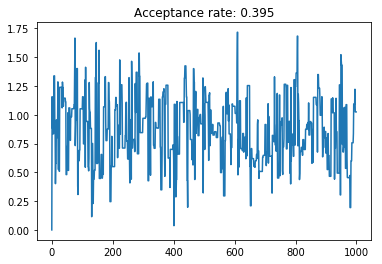

In [126]:
plt.plot(trace)
plt.title(' '.join(['Acceptance rate:', str(accept)]));

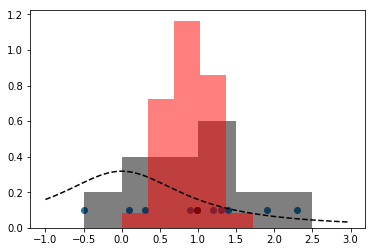

In [131]:
plt.hist(y, bins=np.arange(-.5, 3, .5), histtype='bar', alpha=.5, density=True, color='k');
plt.hist(trace, bins=5, histtype='bar', alpha=.5, density=True, color='r');
plt.scatter(y, np.ones(y.shape) * .1, marker='o')
plt.scatter(ybar, .1, c='k')
plt.plot(t_range, t_vals, 'k--')

## Gibbs Sampling

### Example: Continuation of the previous example, but we also want to estimate the std deviation of the normal distribution

In [132]:
def update_mu(n, ybar, sig2, mu_0, sig2_0):
    sig2_l = 1.0 / (n / sig2 + 1 / sig2_0)
    mu_l = sig2_l * (n * ybar / sig2 + mu_0 / sig2_0)
    return np.random.normal(loc=mu_l, scale=sig2_l)

In [384]:
def update_sig2(n, y, mu, nu_0, beta_0):
    nu_l = nu_0 + n / 2.
    beta_l = beta_0 + np.sum((y - mu) ** 2) / 2.
    out_gamma = np.random.gamma(shape=nu_l, scale=beta_l)
    return out_gamma

In [385]:
def gibbs(y, n_iter, init, prior):
    ybar = np.mean(y)
    n = y.shape[0]
    
    mu_out = np.zeros(n_iter)
    sig2_out = np.zeros(n_iter)
    
    # let's start by mu
    mu_out[0] = init['mu']
    
    # Gibbs samples
    for ind in range(1, n_iter):
        # since we started by the current draw from mu, we start by updating the sig2
        sig2_out[ind] = update_sig2(n=n, y=y, mu=mu_out[ind-1], nu_0=prior['nu'], beta_0=prior['beta'])
        # now that we have updated sig2, we can update mu again
        mu_out[ind] = update_mu(n=n, ybar=ybar, sig2=sig2_out[ind], mu_0=prior['mu'], sig2_0=prior['sig2'])
        
    return mu_out, sig2_out

In [431]:
# generate some data
y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, .99, 0.1, 1.3, 1.9])

ybar = np.mean(y)
n = y.shape[0]

# init
init = {'mu': 0.0, 'sig2': 1.0}

# the prior
prior = {'mu': 0.0, 'sig2': 1.0, 'nu': -n/2 + .5, 'beta': -ybar + .5}

# Let's sample from our posterior
np.random.seed(27)
mu_trace, sig2_trace = gibbs(y=y, n_iter=300, init=init, prior=prior)

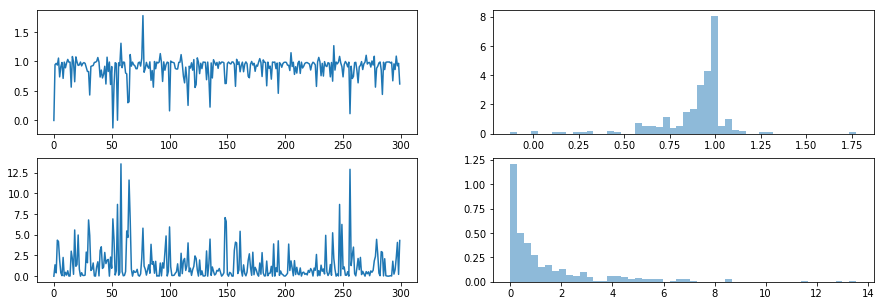

In [432]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
ax1.plot(mu_trace)
ax2.hist(mu_trace, bins=50, histtype='bar', alpha=.5, density=True);

ax3.plot(sig2_trace)
ax4.hist(sig2_trace, bins=50, histtype='bar', alpha=.5, density=True);

In [439]:
autocorr = np.correlate(mu_trace, mu_trace, 'same')

In [441]:
mu_trace.shape

(300,)